In [1]:
# Import basic packages
import pandas as pd
import numpy as np
from pathlib import Path

# Import skleanr packages
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import _name_estimators, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb

In [2]:
__file__ = Path("submissions") / "starting_kit" / "estimator.py"

train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")

In [4]:
pd.concat([train, test])

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,6.100319
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.983607
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,5.389072
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2021-09-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.091042


# End Functions

In [5]:
def _merge_external(X):  
    X = X.copy()
    X.loc[:, "date"] = pd.to_datetime(X["date"])
    file_path = Path(__file__).parent / "external_data.csv"
    df_weather = pd.read_csv(file_path, parse_dates=["date"])

    cols_initial = df_weather.columns.str
    new_colnames = cols_initial.strip()
    df_weather.columns = new_colnames

    X_weather = df_weather[["date", "t", "u", "vv", "ff", "rafper"]]
    X_weather = X_weather.rename(
        columns={'date' : 'date', 'u': 'humidity', 't': 'temperature', 'vv': 'horizontal visibility', 'ff': 'wind velocity', 'rafper': 'gusts over period'})
    
    X["orig_index"] = np.arange(X.shape[0])
    X= pd.merge_asof(X.sort_values("date"), X_weather.sort_values("date"), on='date')

    X = X.sort_values("orig_index")
    del X["orig_index"]

    return X

In [6]:
def _encode_dates(X):
    d = SchoolHolidayDates()
    holidays_list = list(set(list(d.holidays_for_year_and_zone(2020, 'C').keys()) + list(d.holidays_for_year_and_zone(2021, 'C').keys())))
    public_holiday = list(JoursFeries.for_year(2020).values()) + list(JoursFeries.for_year(2021).values())
    X = X.copy()
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    X.loc[:, 'holiday'] = pd.to_datetime(X['date']).dt.date.isin(holidays_list).astype(int)
    X.loc[:, 'public_holiday'] = pd.to_datetime(X['date']).dt.date.isin(public_holiday).astype(int)
    return X.drop(columns=["date"])

In [7]:
__file__ = Path("submissions") / "starting_kit" / "estimator.py"

train_merge = _merge_external(train)
train_merge

train_merge_2 = _encode_dates(train_merge)
train_merge_2

,counter_id,counter_name,site_id,site_name,bike_count,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count,...,horizontal visibility,wind velocity,gusts over period,year,month,day,weekday,hour,holiday,public_holiday
107,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,...,30000,1.6,3.1,2020,9,1,1,2,0,0
157,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147,...,25000,1.1,1.5,2020,9,1,1,3,0,0
193,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,...,25000,1.1,1.5,2020,9,1,1,4,0,0
769,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438,...,30000,4.0,7.5,2020,9,1,1,15,0,0
959,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585,...,30000,3.0,6.5,2020,9,1,1,18,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453515,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,51.0,2020-11-29,Y2H20114504,48.839770,2.301980,3.951244,...,25000,4.1,10.1,2021,8,8,6,18,1,0
453934,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,1.0,2020-11-29,Y2H20114504,48.839770,2.301980,0.693147,...,25000,2.3,5.4,2021,8,9,0,2,1,0
454316,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,61.0,2020-11-29,Y2H20114504,48.839770,2.301980,4.127134,...,19690,3.3,4.7,2021,8,9,0,8,1,0
454411,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,44.0,2020-11-29,Y2H20114504,48.839770,2.301980,3.806662,...,20000,3.5,6.6,2021,8,9,0,10,1,0


In [8]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
encoded_dates = date_encoder.fit_transform(train[["date"]])

encoded_dates

,year,month,day,weekday,hour,holiday,public_holiday
48321,2020,9,1,1,2,0,0
48324,2020,9,1,1,3,0,0
48327,2020,9,1,1,4,0,0
48330,2020,9,1,1,15,0,0
48333,2020,9,1,1,18,0,0
...,...,...,...,...,...,...,...
928450,2021,8,8,6,18,1,0
928453,2021,8,9,0,2,1,0
928456,2021,8,9,0,8,1,0
928459,2021,8,9,0,10,1,0


# Dealing with null bike_count

In [9]:
# Watch out the 2 counters on site '254 rue de Vaugirard' - installed on the 29-11-2020 only

l = train['counter_name'].unique()
r = {}
for i in l:
    counter_name = train[train['counter_name']==i]['counter_installation_date'].min()
    r.setdefault(i, counter_name)

for i in r:
    if r[i] > pd.Timestamp('2020-09-01 00:00:00'):
        print(i, ': ', r[i])

254 rue de Vaugirard NE-SO :  2020-11-29 00:00:00
254 rue de Vaugirard SO-NE :  2020-11-29 00:00:00


In [10]:
# Compute the number of days with null bike_count

X = train.copy()
X.loc[:, "date_only"] = pd.to_datetime(X['date']).dt.date
X_grouped = pd.DataFrame(X.groupby(["counter_name", "date_only"])["bike_count"].sum(), columns=['bike_count'])
X_grouped.reset_index(inplace=True)
X_grouped = X_grouped[X_grouped['bike_count']==0]
X_grouped = pd.DataFrame(X_grouped.groupby(["date_only"])["bike_count"].min(), columns=['bike_count'])
X_grouped.reset_index(inplace=True)
print(len(X_grouped['date_only'].unique()), 'days with at least one counter off')

226 days with at least one counter off


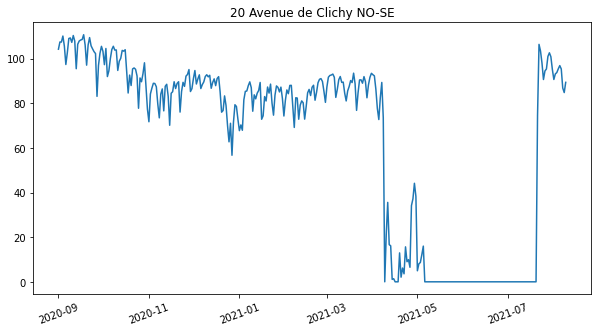

In [153]:
# Plot all bike_count evolution over the year for each counter

from matplotlib import pyplot as plt

counters = train["counter_name"].unique()

#for counter in counters:
#for counter in ['152 boulevard du Montparnasse E-O', '152 boulevard du Montparnasse O-E', '20 Avenue de Clichy NO-SE', '20 Avenue de Clichy SE-NO', '254 rue de Vaugirard NE-SO', '254 rue de Vaugirard SO-NE', 'Voie Georges Pompidou NE-SO', 'Voie Georges Pompidou SO-NE']:
for counter in ['20 Avenue de Clichy NO-SE']:
    mask = train["counter_name"] == counter
    count_by_day_counter = train[mask].groupby(pd.Grouper(freq="1d", key="date"))[["log_bike_count"]].sum()
    plt.figure(figsize=(10,5))
    plt.plot(train[mask].groupby(pd.Grouper(freq="1d", key="date"))[["log_bike_count"]].sum());
    plt.title(counter)
    plt.xticks(rotation=20);
    plt.savefig("clichy.jpg")

In [12]:
# Isolate the counters with null daily bike_count (missing values)

X = train.copy()
X.loc[:, "date_only"] = pd.to_datetime(X['date']).dt.date
X_grouped = pd.DataFrame(X.groupby(["counter_name", "date_only"])["bike_count"].sum(), columns=['bike_count'])
X_grouped.reset_index(inplace=True)
X_grouped = X_grouped[X_grouped['bike_count']==0]
X_bug = pd.DataFrame(X_grouped.groupby('counter_name')['bike_count'].count())
X_bug.reset_index(inplace=True)
X_bug = X_bug[X_bug['bike_count']>0]
X_bug

,counter_name,bike_count
0,152 boulevard du Montparnasse E-O,29
1,152 boulevard du Montparnasse O-E,29
4,20 Avenue de Clichy NO-SE,80
5,20 Avenue de Clichy SE-NO,79
6,254 rue de Vaugirard NE-SO,99
7,254 rue de Vaugirard SO-NE,99
54,Voie Georges Pompidou NE-SO,18
55,Voie Georges Pompidou SO-NE,18


Voie Georges Pompidou NE-SO : 18 days without bikes
Voie Georges Pompidou SO-NE : 18 days without bikes
152 boulevard du Montparnasse E-O : 29 days without bikes
152 boulevard du Montparnasse O-E : 29 days without bikes
20 Avenue de Clichy NO-SE : 80 days without bikes
20 Avenue de Clichy SE-NO : 79 days without bikes


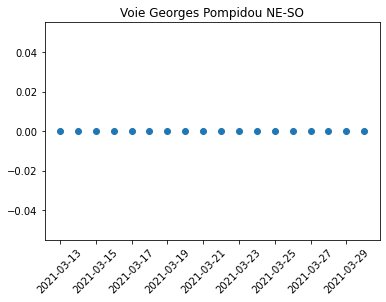

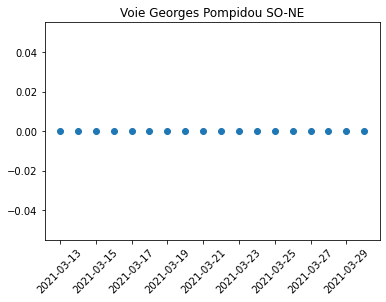

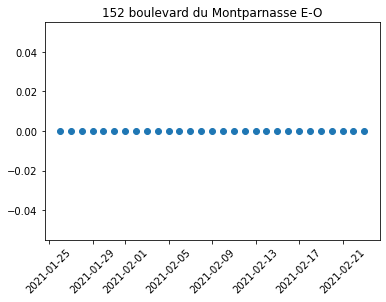

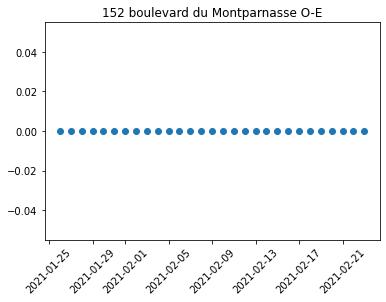

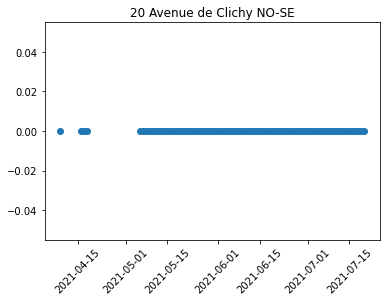

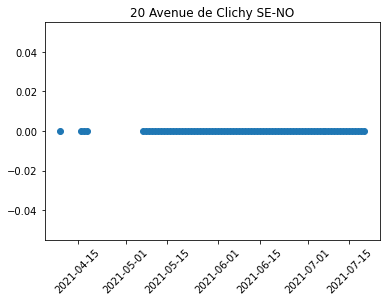

In [13]:
# Isolate the counters with null daily bike_count (missing values)
# and plot the repartition of those bugs over the year

counters = train["counter_name"].unique()

for counter in counters:
    mask = train["counter_name"] == counter
    count_by_day_counter = train[mask].groupby(pd.Grouper(freq="1d", key="date"))[["bike_count"]].sum()
    
    if count_by_day_counter['bike_count'].min() == 0.0 :
        try :
            null_values = count_by_day_counter[count_by_day_counter['bike_count'] == 0]
            count_null = len(null_values)
            print(counter, ':', count_null, 'days without bikes')
            plt.figure()
            plt.scatter(null_values.index, null_values['bike_count'])
            plt.title(counter)
            plt.xticks(rotation=45)
            #plt.legend();
        except :
            pass

In [14]:
# Isolate the counters with null daily bike_count (missing values)
# and plot the repartition of those bugs over the year


mask = train["counter_name"] == counter
count_by_day_counter = train.groupby([pd.Grouper(freq="1d", key="date"), 'counter_name'])[["bike_count"]].sum()
print(count_by_day_counter)

                                              bike_count
date       counter_name                                 
2020-09-01 152 boulevard du Montparnasse E-O      1603.0
           152 boulevard du Montparnasse O-E      1495.0
           18 quai de l'Hôtel de Ville NO-SE      1554.0
           18 quai de l'Hôtel de Ville SE-NO      2465.0
           20 Avenue de Clichy NO-SE              3522.0
...                                                  ...
2021-08-09 Totem 85 quai d'Austerlitz SE-NO       1558.0
           Totem Cours la Reine E-O                794.0
           Totem Cours la Reine O-E               1667.0
           Voie Georges Pompidou NE-SO             479.0
           Voie Georges Pompidou SO-NE             845.0

[19208 rows x 1 columns]


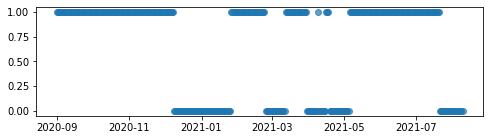

In [71]:
grouped_by_counter_date = train.groupby(['counter_name', pd.Grouper(freq="1d", key="date")])[["bike_count"]].sum()
null_dates = grouped_by_counter_date[grouped_by_counter_date['bike_count']==0.0]
null_dates.reset_index(inplace=True)
null_dates = null_dates['date'].unique()
null_dates.sort()
#print(null_dates)
data_dates = pd.date_range('2020-09-01','2021/08/09',freq='d')

#print(data_dates)
df_dates = data_dates.to_frame()
df_dates.reset_index(inplace=True)
df_dates.rename(columns={"index": "date"}, inplace=True)
df_dates.drop(columns=0, inplace=True)
df_dates['counter_off'] = df_dates['date'].isin(null_dates)
plt.figure(figsize=(8, 2))
plt.scatter(df_dates['date'], df_dates['counter_off'], alpha=0.7);
plt.savefig("clichy.jpg")

# Reformating the data for missing values prediction

In [45]:
# reconstructing whole dataframe
frames = [train, test]
full_dataset = pd.concat(frames)

In [46]:
full_dataset

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,6.100319
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.983607
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,5.389072
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2021-09-09 22:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.091042


In [47]:
# Merge external data

data_enriched = _merge_external(full_dataset)


data_prep = data_enriched[['counter_name', 'date', 'log_bike_count', 'temperature']]



# Encode the entire dataframe

data_encoded = _encode_dates(data_prep)
counter_name_encoded = OrdinalEncoder().fit_transform(data_encoded.counter_name.to_numpy()[:, None])
data_encoded['num_counter'] = counter_name_encoded.astype(int)
data_encoded.drop(columns='counter_name', inplace=True)
data_encoded['temperature'] = StandardScaler().fit_transform(data_encoded.temperature.to_numpy()[:, None])

data = data_encoded

log_pivoted = pd.get_dummies(data['num_counter']).mul(data.log_bike_count,0)
log_pivoted.columns = ['log_' + str(col_num) for col_num in log_pivoted.columns]
data_pivoted = data.join(log_pivoted)
data_pivoted.drop(columns=['num_counter', 'log_bike_count'], inplace=True)

maille = ['year', 'month', 'day', 'weekday', 'hour', 'holiday', 'public_holiday', 'temperature']
data_agg = data_pivoted.groupby(maille).sum()
data_agg.reset_index(inplace=True)
data_agg

# Check equality before/after aggregation
#round(data_agg.iloc[:, 8:].sum().sum(), 5) == round(sum(full_dataset.log_bike_count), 5)

,year,month,day,weekday,hour,holiday,public_holiday,temperature,log_0,log_1,...,log_46,log_47,log_48,log_49,log_50,log_51,log_52,log_53,log_54,log_55
0,2020,9,1,1,1,0,0,0.018089,1.609438,1.386294,...,0.693147,2.708050,1.098612,2.397895,1.609438,1.609438,1.098612,0.000000,0.000000,0.000000
1,2020,9,1,1,2,0,0,0.018089,0.000000,0.693147,...,1.791759,1.791759,1.609438,2.079442,0.693147,1.609438,0.000000,1.098612,1.098612,1.098612
2,2020,9,1,1,3,0,0,-0.237371,1.098612,1.945910,...,2.197225,2.639057,2.995732,2.302585,2.833213,2.397895,1.945910,1.791759,1.386294,2.484907
3,2020,9,1,1,4,0,0,-0.237371,2.833213,2.944439,...,3.761200,3.135494,4.127134,3.784190,3.401197,3.091042,3.135494,3.258097,2.484907,3.555348
4,2020,9,1,1,5,0,0,-0.237371,4.060443,4.174387,...,5.273000,4.488636,5.288267,5.298317,4.553877,4.653960,4.330733,4.736198,3.526361,5.081404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,2021,9,9,3,19,0,0,1.125082,4.158883,3.637586,...,5.030438,5.902633,5.351858,6.001415,4.234107,4.852030,7.172425,4.828314,3.806662,3.663562
8969,2021,9,9,3,20,0,0,1.125082,4.158883,3.367296,...,4.727388,5.605802,5.424950,6.104793,4.262680,4.574711,4.477337,4.521789,3.951244,3.555348
8970,2021,9,9,3,21,0,0,0.940583,3.713572,3.218876,...,4.553877,5.620401,5.455321,5.945421,3.931826,4.795791,4.219508,4.663439,3.850148,3.526361
8971,2021,9,9,3,22,0,0,0.940583,3.496508,2.772589,...,4.532599,5.283204,4.941642,5.513429,3.761200,4.382027,4.025352,4.418841,3.610918,3.258097


In [48]:
logs = ["log_" + str(i) for i in range(56)]
maille_by_day = ['year', 'month', 'day', 'weekday', 'holiday', 'public_holiday']
data_agg_by_day = data_agg.groupby(maille_by_day).sum()
data_agg_by_day.reset_index(inplace=True)

count_nulls_by_counter = data_agg_by_day[data_agg_by_day[logs]==0].count()
count_nulls_by_counter
counters_to_pred_with_count_nulls = count_nulls_by_counter[count_nulls_by_counter > 0].to_frame().sort_values(0, ascending=False)
counters_to_pred = list(counters_to_pred_with_count_nulls.index)
print(f'Counters with missing data: \n{counters_to_pred_with_count_nulls}\n')
print(f'The counters to predict: {counters_to_pred}\n')

predictionary = {}

for log in counters_to_pred:
    if data_agg_by_day[data_agg_by_day[log] == 0][log].count() > 0 :
        indexes = data_agg_by_day[data_agg_by_day[log] == 0].index
        list_datetime = []
        for i in indexes:
            row = data_agg_by_day.loc[i]
            date = datetime.datetime(int(row.year), int(row.month), int(row.day))
            list_datetime.append(date)
        predictionary[log] = list_datetime

Counters with missing data: 
         0
log_6   99
log_7   99
log_4   80
log_5   79
log_0   29
log_1   29
log_54  18
log_55  18

The counters to predict: ['log_6', 'log_7', 'log_4', 'log_5', 'log_0', 'log_1', 'log_54', 'log_55']



#### Predict log_6

In [72]:
X = data_agg.copy()
X['datetime'] = X['year'].astype(str) + '/' + X['month'].astype(str) + '/' + X['day'].astype(str)
X['datetime'] = X['datetime'].astype('datetime64[ns]')

log = 'log_4'

train_set = X[~X['datetime'].isin(predictionary[log])].drop(columns='datetime')
test_set = X[X['datetime'].isin(predictionary[log])].drop(columns='datetime')

X_train = train_set.drop(columns=log)
y_train = train_set[log]
X_test = test_set.drop(columns=log)

In [109]:
from sklearn.linear_model import Ridge

model = Ridge().fit(X_train, y_train)
y_pred = model.predict(X_test)

In [165]:
test_set_new = test_set.copy()
test_set_new[log] = y_pred**0.5 + 3

X_new = pd.concat([train_set, test_set_new])
X_new

/var/folders/xq/lq414ksd5g18kww0vlln1flr0000gn/T/ipykernel_74483/498553420.py:2: RuntimeWarning: invalid value encountered in sqrt
  test_set_new[log] = y_pred**0.5 + 3


,year,month,day,weekday,hour,holiday,public_holiday,temperature,log_0,log_1,...,log_46,log_47,log_48,log_49,log_50,log_51,log_52,log_53,log_54,log_55
0,2020,9,1,1,1,0,0,0.018089,1.609438,1.386294,...,0.693147,2.708050,1.098612,2.397895,1.609438,1.609438,1.098612,0.000000,0.000000,0.000000
1,2020,9,1,1,2,0,0,0.018089,0.000000,0.693147,...,1.791759,1.791759,1.609438,2.079442,0.693147,1.609438,0.000000,1.098612,1.098612,1.098612
2,2020,9,1,1,3,0,0,-0.237371,1.098612,1.945910,...,2.197225,2.639057,2.995732,2.302585,2.833213,2.397895,1.945910,1.791759,1.386294,2.484907
3,2020,9,1,1,4,0,0,-0.237371,2.833213,2.944439,...,3.761200,3.135494,4.127134,3.784190,3.401197,3.091042,3.135494,3.258097,2.484907,3.555348
4,2020,9,1,1,5,0,0,-0.237371,4.060443,4.174387,...,5.273000,4.488636,5.288267,5.298317,4.553877,4.653960,4.330733,4.736198,3.526361,5.081404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7745,2021,7,20,1,19,1,0,2.118537,3.912023,3.465736,...,4.499810,5.669881,5.379897,5.880533,4.564348,4.744932,4.356709,4.867534,4.007333,4.158883
7746,2021,7,20,1,20,1,0,2.118537,3.931826,3.258097,...,4.418841,5.579730,5.389072,5.955837,4.510860,4.787492,4.007333,4.736198,3.828641,3.610918
7747,2021,7,20,1,21,1,0,1.536656,3.871201,3.258097,...,4.465908,5.723585,5.509388,5.883322,4.276666,4.532599,4.330733,4.644391,3.663562,3.737670
7748,2021,7,20,1,22,1,0,1.536656,3.178054,2.772589,...,3.988984,5.241747,4.969813,5.505332,3.496508,4.304065,3.737670,3.871201,3.555348,3.258097


In [166]:
maille = ['year', 'month', 'day', 'weekday', 'hour', 'holiday', 'public_holiday', 'temperature']
logs = ["log_" + str(i) for i in range(56)]

data_new = pd.melt(X_new, id_vars=maille, value_vars=logs)
#data_new['value'] = np.exp(data_new['value'])

In [167]:
data_new

,year,month,day,weekday,hour,holiday,public_holiday,temperature,variable,value
0,2020,9,1,1,1,0,0,0.018089,log_0,1.609438
1,2020,9,1,1,2,0,0,0.018089,log_0,0.000000
2,2020,9,1,1,3,0,0,-0.237371,log_0,1.098612
3,2020,9,1,1,4,0,0,-0.237371,log_0,2.833213
4,2020,9,1,1,5,0,0,-0.237371,log_0,4.060443
...,...,...,...,...,...,...,...,...,...,...
502483,2021,7,20,1,19,1,0,2.118537,log_55,4.158883
502484,2021,7,20,1,20,1,0,2.118537,log_55,3.610918
502485,2021,7,20,1,21,1,0,1.536656,log_55,3.737670
502486,2021,7,20,1,22,1,0,1.536656,log_55,3.258097


In [168]:
train.dtypes

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
bike_count                          float64
date                         datetime64[ns]
counter_installation_date    datetime64[ns]
counter_technical_id               category
latitude                            float64
longitude                           float64
log_bike_count                      float64
dtype: object

<Figure size 432x288 with 0 Axes>

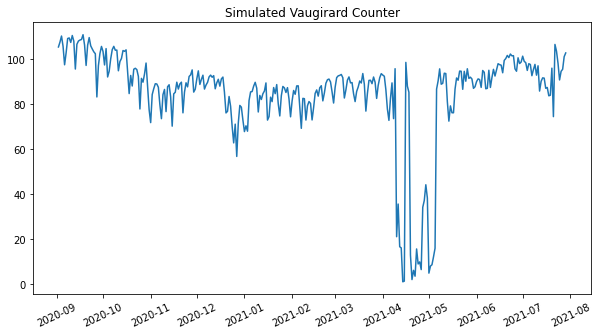

In [172]:
counter = 'log_4'
data_new['datetime'] = data_new['year'].astype(str) + '/' + data_new['month'].astype(str) + '/' + data_new['day'].astype(str) + ' ' + data_new['hour'].astype(str) + ':00:00'
data_new['datetime'] = data_new['datetime'].astype('datetime64[ns]')

mask = (
    (data_new["variable"] == "log_4")
    & (data_new["datetime"] > pd.to_datetime("2020/09/02"))
    & (data_new["datetime"] < pd.to_datetime("2021/07/30"))
)

count_by_day_counter = data_new[mask].groupby(pd.Grouper(freq="1d", key="datetime"))[["value"]].sum()
plt.figure()
plt.figure(figsize=(10,5))
plt.plot(data_new[mask].groupby(pd.Grouper(freq="1d", key="datetime"))[["value"]].sum());
plt.title('Simulated Vaugirard Counter')
plt.xticks(rotation=25);
plt.savefig("clichy_simulated.jpg")

In [147]:
data_new['datetime'] = data_new['year'].astype(str) + '/' + data_new['month'].astype(str) + '/' + data_new['day'].astype(str) + ' ' + data_new['hour'].astype(str) + ':00:00'
data_new['datetime'].astype('datetime64[ns]')

0        2020-09-01 01:00:00
1        2020-09-01 02:00:00
2        2020-09-01 03:00:00
3        2020-09-01 04:00:00
4        2020-09-01 05:00:00
                 ...        
502483   2021-07-20 19:00:00
502484   2021-07-20 20:00:00
502485   2021-07-20 21:00:00
502486   2021-07-20 22:00:00
502487   2021-07-20 23:00:00
Name: datetime, Length: 502488, dtype: datetime64[ns]

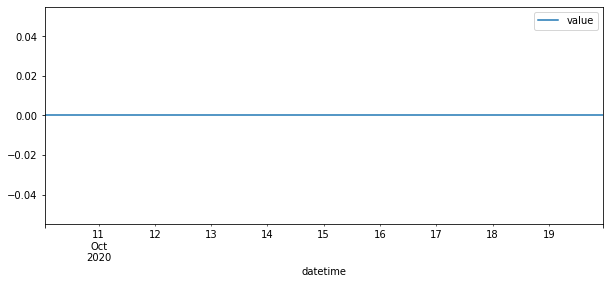

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data_new["variable"] == "log_7")
    & (data_new["datetime"] > pd.to_datetime("2020/10/10"))
    & (data_new["datetime"] < pd.to_datetime("2020/10/20"))
)

data_new[mask].plot(x="datetime", y="value", ax=ax);

In [ ]:
data_new['datetime'] = data_new['year'].astype(str) + '/' + data_new['month'].astype(str) + '/' + data_new['day'].astype(str) + ' ' + data_new['hour'].astype(str) + ':00:00'
data_new['datetime'].astype('datetime64[ns]')

In [ ]:
train[mask].groupby(pd.Grouper(freq="1d", key="datetime"))[["value"]].sum()

In [287]:
from prophet import Prophet

In [306]:
X = data[['counter_name', 'date', 'log_bike_count']]

# Define X and y
X_clichy_nose = data[data.counter_name != '20 Avenue de Clichy NO-SE']
y_clichy_nose = data[data.counter_name == '20 Avenue de Clichy NO-SE']

X = X_clichy_nose
y = y_clichy_nose

# Define X_train, y_train, X_pred

## dates_pred
y_by_day = y.groupby(pd.Grouper(freq="1d", key="date")).sum()
y_by_day.reset_index(inplace=True)
pred_dates = y_by_day[y_by_day.bike_count == 0]['date'].dt.date.to_numpy()
train_dates = y_by_day[y_by_day.bike_count > 0]['date'].dt.date.to_numpy()

y_copy = y.copy()
y_copy['date_only'] = y_copy['date'].dt.date

y_pred_prep = y_copy[y_copy.date_only.isin(pred_dates)]
y_train_prep = y_copy[y_copy.date_only.isin(train_dates)]
y_pred = y_pred_prep.drop(columns='date_only')
y_train = y_train_prep.drop(columns='date_only')

X_copy = X.copy()
X_copy['date_only'] = X_copy['date'].dt.date

X_pred_prep = X_copy[X_copy.date_only.isin(pred_dates)]
X_train_prep = X_copy[X_copy.date_only.isin(train_dates)]
X_pred = X_pred_prep.drop(columns='date_only')
X_train = X_train_prep.drop(columns='date_only')

In [388]:
# Encode the entire dataframe
X = data[['counter_name', 'date', 'log_bike_count']]

X_encoded = _encode_dates(X)
counter_name_encoded = OrdinalEncoder().fit_transform(X_encoded.counter_name.to_numpy()[:, None])
X_encoded['counter'] = counter_name_encoded.astype(int)
X_encoded.drop(columns='counter_name', inplace=True)

X = X_encoded
X

,log_bike_count,year,month,day,weekday,hour,holiday,public_holiday,counter
48321,0.000000,2020,9,1,1,2,0,0,10
48324,0.693147,2020,9,1,1,3,0,0,10
48327,0.000000,2020,9,1,1,4,0,0,10
48330,1.609438,2020,9,1,1,15,0,0,10
48333,2.302585,2020,9,1,1,18,0,0,10
...,...,...,...,...,...,...,...,...,...
929175,6.100319,2021,9,9,3,6,0,0,7
929178,4.983607,2021,9,9,3,10,0,0,7
929181,5.389072,2021,9,9,3,15,0,0,7
929184,3.091042,2021,9,9,3,22,0,0,7


In [389]:
#X = X.set_index('counter', 'log_bike_count').unstack(['counter'])

log_pivoted = pd.get_dummies(X['counter']).mul(X.log_bike_count,0)
log_pivoted.columns = ['log_' + str(col_num) for col_num in log_pivoted.columns]
X = X.join(log_pivoted)
X

,log_bike_count,year,month,day,weekday,hour,holiday,public_holiday,counter,log_0,...,log_46,log_47,log_48,log_49,log_50,log_51,log_52,log_53,log_54,log_55
48321,0.000000,2020,9,1,1,2,0,0,10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48324,0.693147,2020,9,1,1,3,0,0,10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48327,0.000000,2020,9,1,1,4,0,0,10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48330,1.609438,2020,9,1,1,15,0,0,10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48333,2.302585,2020,9,1,1,18,0,0,10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929175,6.100319,2021,9,9,3,6,0,0,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929178,4.983607,2021,9,9,3,10,0,0,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929181,5.389072,2021,9,9,3,15,0,0,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929184,3.091042,2021,9,9,3,22,0,0,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [390]:
print(X.iloc[:, 9:].sum().sum()) 
print(sum(X.log_bike_count))

1530110.9879094386
1530110.987910831


In [391]:
maille = ['year', 'month', 'day', 'weekday', 'hour', 'holiday', 'public_holiday']
X = X.groupby(maille).sum()
X = X.drop(columns=['log_bike_count', 'counter'])

In [392]:
## FINALLY ! 

X.reset_index(inplace=True)
X

,year,month,day,weekday,hour,holiday,public_holiday,log_0,log_1,log_2,...,log_46,log_47,log_48,log_49,log_50,log_51,log_52,log_53,log_54,log_55
0,2020,9,1,1,1,0,0,1.609438,1.386294,0.000000,...,0.693147,2.708050,1.098612,2.397895,1.609438,1.609438,1.098612,0.000000,0.000000,0.000000
1,2020,9,1,1,2,0,0,0.000000,0.693147,0.000000,...,1.791759,1.791759,1.609438,2.079442,0.693147,1.609438,0.000000,1.098612,1.098612,1.098612
2,2020,9,1,1,3,0,0,1.098612,1.945910,0.000000,...,2.197225,2.639057,2.995732,2.302585,2.833213,2.397895,1.945910,1.791759,1.386294,2.484907
3,2020,9,1,1,4,0,0,2.833213,2.944439,2.079442,...,3.761200,3.135494,4.127134,3.784190,3.401197,3.091042,3.135494,3.258097,2.484907,3.555348
4,2020,9,1,1,5,0,0,4.060443,4.174387,3.258097,...,5.273000,4.488636,5.288267,5.298317,4.553877,4.653960,4.330733,4.736198,3.526361,5.081404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,2021,9,9,3,19,0,0,4.158883,3.637586,3.637586,...,5.030438,5.902633,5.351858,6.001415,4.234107,4.852030,7.172425,4.828314,3.806662,3.663562
8969,2021,9,9,3,20,0,0,4.158883,3.367296,3.663562,...,4.727388,5.605802,5.424950,6.104793,4.262680,4.574711,4.477337,4.521789,3.951244,3.555348
8970,2021,9,9,3,21,0,0,3.713572,3.218876,3.496508,...,4.553877,5.620401,5.455321,5.945421,3.931826,4.795791,4.219508,4.663439,3.850148,3.526361
8971,2021,9,9,3,22,0,0,3.496508,2.772589,3.295837,...,4.532599,5.283204,4.941642,5.513429,3.761200,4.382027,4.025352,4.418841,3.610918,3.258097


In [465]:
logs = ["log_" + str(i) for i in range(56)]
grouping_list = ['year', 'month', 'day', 'weekday', 'holiday', 'public_holiday']
X_by_day = X.groupby(grouping_list).sum()
X_by_day.reset_index(inplace=True)

X_by_day_logs_only = X_by_day[logs]
count_nulls_by_counter = X_by_day_logs_only[X_by_day_logs_only==0].count()
counters_to_pred_with_count_nulls = count_nulls_by_counter[count_nulls_by_counter > 0].to_frame().sort_values(0, ascending=False)
counters_to_pred = list(counters_to_pred_with_count_nulls.index)
print(f'Counters with missing data: \n{counters_to_pred_with_count_nulls}\n')
print(f'The counters to predict: {counters_to_pred}')

Counters with missing data: 
         0
log_6   99
log_7   99
log_4   80
log_5   79
log_0   29
log_1   29
log_54  18
log_55  18

The counters to predict: ['log_6', 'log_7', 'log_4', 'log_5', 'log_0', 'log_1', 'log_54', 'log_55']


In [466]:
X_by_day

,year,month,day,weekday,holiday,public_holiday,hour,log_0,log_1,log_2,...,log_46,log_47,log_48,log_49,log_50,log_51,log_52,log_53,log_54,log_55
0,2020,9,1,1,0,0,276,85.569543,84.368019,79.084968,...,101.185182,118.449420,116.298516,122.062379,95.570298,103.736640,88.219539,101.244500,83.835807,94.585155
1,2020,9,2,2,0,0,276,88.483939,88.697464,82.930549,...,104.823080,120.692643,122.238933,129.491756,98.261352,106.107809,90.557734,107.943151,86.511371,98.619743
2,2020,9,3,3,0,0,276,90.471005,86.200854,81.959426,...,108.467032,123.288669,124.334615,130.242298,100.690117,106.938732,93.196073,105.883543,88.842984,100.404113
3,2020,9,4,4,0,0,276,84.935395,92.475641,84.125854,...,109.454718,125.553846,125.709763,131.103448,102.843379,110.910618,94.002280,111.557720,89.513125,101.739725
4,2020,9,5,5,0,0,276,84.907625,83.953394,78.617833,...,105.970205,122.728366,123.051351,126.213386,94.746858,99.756219,85.015571,103.196742,77.763618,94.281752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,2021,9,5,6,0,0,276,80.271744,73.438169,69.845563,...,100.381042,112.007367,116.133184,121.125307,91.291729,99.309121,84.399503,107.412847,78.008069,86.309537
370,2021,9,6,0,0,0,276,86.321563,82.793847,71.980154,...,111.634991,118.104310,120.977412,127.320814,97.177239,105.108258,90.323502,106.692715,79.232527,91.450862
371,2021,9,7,1,0,0,276,88.066010,85.994361,76.366456,...,113.250707,121.919754,123.908606,130.289984,100.122839,107.971503,93.864227,110.774683,86.818099,96.322530
372,2021,9,8,2,0,0,276,88.671044,86.077526,75.770758,...,113.317294,119.700132,123.524214,127.209063,99.146976,107.017984,95.445446,107.371846,85.570433,94.752328


# Predict Clichy missing data

In [314]:
#pivot_list = ['year', 'month', 'day', 'weekday', 'hour', 'public_holiday']
#value_vars = ['counter', 'log_bike_count']

#pd.melt(X, id_vars=pivot_list, value_vars=value_vars)

,year,month,day,weekday,hour,public_holiday,variable,value
0,2020,9,1,1,2,0,counter,10.000000
1,2020,9,1,1,3,0,counter,10.000000
2,2020,9,1,1,4,0,counter,10.000000
3,2020,9,1,1,15,0,counter,10.000000
4,2020,9,1,1,18,0,counter,10.000000
...,...,...,...,...,...,...,...,...
993537,2021,9,9,3,6,0,log_bike_count,6.100319
993538,2021,9,9,3,10,0,log_bike_count,4.983607
993539,2021,9,9,3,15,0,log_bike_count,5.389072
993540,2021,9,9,3,22,0,log_bike_count,3.091042


In [261]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [264]:
X_train

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
87516,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020
98518,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020
875137,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,Y2H20073268,48.885290,2.326660
...,...,...,...,...,...,...,...,...,...
794577,100057329-103057329,Totem 85 quai d'Austerlitz SE-NO,100057329,Totem 85 quai d'Austerlitz,2021-08-09 23:00:00,2020-02-18,YTH19111508,48.842010,2.367290
804787,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2021-08-09 23:00:00,2020-02-11,YTH19111509,48.864620,2.314440
814377,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-08-09 23:00:00,2020-02-11,YTH19111509,48.864620,2.314440
125899,100042374-110042374,Voie Georges Pompidou NE-SO,100042374,Voie Georges Pompidou,2021-08-09 23:00:00,2017-12-15,Y2H21025335,48.848400,2.275860


In [325]:
dummies = pd.get_dummies(X['CategoryColumn']).mul(df.ActualValueColumn,0)

NameError: name 'df' is not defined